In [3]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

from sklearn.metrics import mean_squared_error
from PIL import Image
import torch
from torch.utils.data import Dataset

# fix torch random seed
torch.manual_seed(0)

In [4]:
import pandas as pd
path2csv = './database/metadata.csv'
df = pd.read_csv(path2csv)
dir_list = []
for i in range(len(df)):
    dir_list.append('./'+df['directory'][i])
df.drop(['name','index'], axis=1, inplace=True)
#df.drop(['a','v'], axis=1, inplace=True)
df.tail(3)

,directory,heat,weight,colorfulness,saturation,brightness,pleasure,dominance,horizontal_intensity,vertical_intensity,...,waveletAV,waveletAD,waveletBH,waveletBV,waveletBD,vertical_similarity,horizontal_similarity,ruleOfThirds,a,v
54,database/painting/055.jpg,0.502064,1.075300,28.727802,0.465279,0.530236,0.468224,-0.254090,0.695328,0.099177,...,-0.000355,0.000574,-0.435728,-0.000355,-0.000574,0.980298,0.962079,0.964504,6.287000,6.471000
55,database/painting/056.jpg,-0.797139,-0.927580,32.892406,0.508540,0.548231,0.490158,-0.253923,0.000000,0.557676,...,-0.000109,0.001425,0.001237,0.001902,-0.001425,0.955615,0.962532,0.956674,3.582333,5.574667
56,database/painting/057.jpg,1.237772,0.727806,18.670452,0.353079,0.585810,0.481887,-0.332231,2.961220,0.489046,...,0.000000,0.000000,-0.233711,0.000000,0.000000,0.970833,0.958790,0.963362,5.919833,7.268000


In [5]:
from PIL import Image

class paintingDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './database/painting'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = './' + self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        feature = self.metadata.iloc[idx,-2:]
        feature = np.array([feature])
        feature = feature.astype('float').reshape(-1)
        
        #sample = {'image': image, 'feature': feature}
        
        if self.transform is not None:
            image = self.transform(image)

        return image, feature

In [6]:
train_rate = 0.7
num = round(train_rate * len(df))
train_dataset = paintingDataset(df[:num],transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

test_dataset = paintingDataset(df[num:],transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=4, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=4, 
                                             shuffle=False)

torch.Size([4, 3, 224, 224])


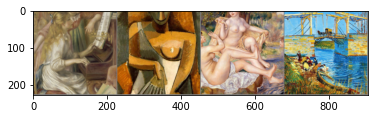

tensor([[4.4177, 3.9810],
        [4.0040, 3.3298],
        [4.8392, 5.8505],
        [5.9273, 2.6860]], dtype=torch.float64)


In [14]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, features = dataiter.next()
print(images.size())
imshow(torchvision.utils.make_grid(images))
print(features)

In [15]:
def testing(model):
    with torch.no_grad():
        a_temp = 0.0
        v_temp = 0.0
        for data in test_loader:
            model = model.to(device)
            model = model.eval()

            inputs, gt = data[0].to(device), data[1].to(device)
            output = model(inputs)

            #print(mean_squared_error(output.cpu(), gt.cpu()))
            #print(output[:,0])
            a_temp += mean_squared_error(output[:,0].cpu(), gt[:,0].cpu())
            v_temp += mean_squared_error(output[:,1].cpu(), gt[:,1].cpu())
        A_MSE = a_temp / len(train_loader)
        V_MSE = v_temp / len(train_loader)
    return A_MSE, V_MSE

In [34]:
from model.resnet import *
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = resnet18().to(device)

num_epochs = 200
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.00001)

net = model
torchsummary.summary(net, (3, 224, 224), batch_size=4)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           9,408
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]          36,864
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
       BasicBlock-11            [4, 64, 56, 56]               0
           Conv2d-12            [4, 64, 56, 56]          36,864
      BatchNorm2d-13            [4, 64, 56, 56]             128
             ReLU-14            [4

In [22]:
# Resnet34
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        av = model(inputs)
        loss = loss_func(av, gt.float())
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    
    model.eval() 
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            av = model(inputs)
            loss = loss_func(av, gt.float())
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        test_loss_list.append(test_loss)


    print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
    print(testing(model))#a_mse, v_mse = testing(model)[0], testing(model)[1]
    #print('test a_mse %.3f, v_mse %.3f' %(a_mse, v_mse))

[epoch 0] Train loss: 22.488, Test loss: 34.364
(15.189195103703554, 19.16560504524211)
[epoch 1] Train loss: 21.700, Test loss: 34.053
(15.321937780594656, 18.666640388209846)
[epoch 2] Train loss: 20.797, Test loss: 33.439
(15.268689019777758, 18.165732081652205)
[epoch 3] Train loss: 19.998, Test loss: 32.518
(15.055772410806398, 17.506377911981918)
[epoch 4] Train loss: 19.138, Test loss: 31.269
(14.314636209522462, 17.06428707230598)
[epoch 5] Train loss: 18.298, Test loss: 29.922
(13.297895070562253, 16.551230242300868)
[epoch 6] Train loss: 17.329, Test loss: 28.109
(12.066423077081863, 15.841098946886826)
[epoch 7] Train loss: 16.796, Test loss: 26.061
(10.676755628934176, 14.803862496287454)
[epoch 8] Train loss: 15.786, Test loss: 24.999
(10.119007870511577, 14.24965581896024)
[epoch 9] Train loss: 15.122, Test loss: 24.480
(9.941566771358197, 13.56116552761993)
[epoch 10] Train loss: 14.104, Test loss: 23.634
(9.521433449672095, 13.506405672196598)
[epoch 11] Train loss: 13.

[epoch 94] Train loss: 1.602, Test loss: 3.036
(1.3113400747423765, 1.7118883056266483)
[epoch 95] Train loss: 1.517, Test loss: 3.332
(1.7831327152339305, 1.7817935465376042)
[epoch 96] Train loss: 1.484, Test loss: 3.049
(1.3138705457493065, 1.9511883620504697)
[epoch 97] Train loss: 1.856, Test loss: 2.787
(1.2932324689843686, 1.569587136500533)
[epoch 98] Train loss: 1.631, Test loss: 2.649
(1.2675501046415671, 1.638949227533048)
[epoch 99] Train loss: 1.662, Test loss: 3.007
(1.1977848951496133, 1.8316780134139639)
[epoch 100] Train loss: 1.461, Test loss: 3.573
(1.4442859658871807, 1.9538496445994227)
[epoch 101] Train loss: 1.809, Test loss: 3.539
(1.2056381547478694, 2.2566992801905315)
[epoch 102] Train loss: 1.555, Test loss: 3.900
(1.0859587825113552, 2.162592969498389)
[epoch 103] Train loss: 1.537, Test loss: 2.779
(1.1391750042294433, 2.0555096955243393)
[epoch 104] Train loss: 1.523, Test loss: 3.057
(1.21330973814982, 1.9389252470414153)
[epoch 105] Train loss: 1.519, T

[epoch 187] Train loss: 0.596, Test loss: 3.566
(2.076433801002125, 2.042567105764534)
[epoch 188] Train loss: 0.868, Test loss: 4.763
(2.25471888690333, 2.359598508850755)
[epoch 189] Train loss: 0.860, Test loss: 3.905
(1.9043937192356737, 2.5152561797215265)
[epoch 190] Train loss: 0.697, Test loss: 3.521
(1.3501677110064914, 1.9152401931228542)
[epoch 191] Train loss: 0.629, Test loss: 2.879
(0.8934172369500477, 1.9192151858718103)
[epoch 192] Train loss: 0.980, Test loss: 3.062
(1.322272517191914, 1.889423854431341)
[epoch 193] Train loss: 0.519, Test loss: 3.407
(1.3572876177564768, 2.386348699113733)
[epoch 194] Train loss: 0.889, Test loss: 4.231
(1.5809855927098557, 2.5402180786343433)
[epoch 195] Train loss: 0.954, Test loss: 3.627
(1.4126108841338092, 2.3439011378858234)
[epoch 196] Train loss: 0.981, Test loss: 4.146
(1.2375856515688812, 3.2630037160628023)
[epoch 197] Train loss: 0.792, Test loss: 4.624
(1.349701094965079, 2.507541394661098)
[epoch 198] Train loss: 1.112, 

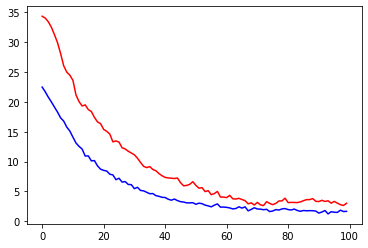

In [25]:
plt.plot(test_loss_list[:100], c='r', label='Test loss')
plt.plot(train_loss_list[:100], c='b', label='Train loss')

In [32]:
# Resnet50
res50_train_loss_list = []
res50_test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        av = model(inputs)
        loss = loss_func(av, gt.float())
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    res50_train_loss_list.append(train_loss)
    
    model.eval() 
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            av = model(inputs)
            loss = loss_func(av, gt.float())
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        res50_test_loss_list.append(test_loss)


    print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
    print(testing(model))#a_mse, v_mse = testing(model)[0], testing(model)[1]
    #print('test a_mse %.3f, v_mse %.3f' %(a_mse, v_mse))

[epoch 0] Train loss: 20.965, Test loss: 34.222
(16.000407374158506, 18.197390997167822)
[epoch 1] Train loss: 18.900, Test loss: 32.514
(14.820361947966239, 17.51127389365619)
[epoch 2] Train loss: 16.847, Test loss: 29.930
(13.443098231978704, 16.612574321483304)
[epoch 3] Train loss: 15.353, Test loss: 27.261
(11.89573828282415, 15.528724662189884)
[epoch 4] Train loss: 13.793, Test loss: 24.996
(10.569268623242765, 14.464310861570208)
[epoch 5] Train loss: 12.386, Test loss: 22.479
(9.303900916190635, 13.265842786852431)
[epoch 6] Train loss: 11.131, Test loss: 20.326
(8.12047671136294, 12.069131775492583)
[epoch 7] Train loss: 10.066, Test loss: 18.856
(7.426380219427361, 11.480433250340848)
[epoch 8] Train loss: 8.980, Test loss: 17.411
(6.912126278129314, 10.642048443763661)
[epoch 9] Train loss: 7.943, Test loss: 15.708
(5.870195770377475, 9.829596944769957)
[epoch 10] Train loss: 7.225, Test loss: 13.638
(4.798443696679259, 8.89331830296271)
[epoch 11] Train loss: 6.385, Test 

[epoch 94] Train loss: 1.942, Test loss: 3.622
(1.1663527375993583, 2.584207994498197)
[epoch 95] Train loss: 1.872, Test loss: 3.701
(1.1097123473592685, 2.74513925386194)
[epoch 96] Train loss: 1.827, Test loss: 3.430
(0.9664733309253897, 2.349623981322555)
[epoch 97] Train loss: 2.021, Test loss: 3.514
(1.1013256846192907, 2.70212762661343)
[epoch 98] Train loss: 1.671, Test loss: 3.373
(0.9751695625477798, 2.351699641154603)
[epoch 99] Train loss: 1.849, Test loss: 3.443
(1.1245838105331756, 2.369387617844928)
[epoch 100] Train loss: 1.847, Test loss: 3.387
(1.03104089853872, 2.407303915938477)
[epoch 101] Train loss: 2.084, Test loss: 3.488
(1.0314235935635958, 2.3801303146911965)
[epoch 102] Train loss: 1.876, Test loss: 3.188
(0.9977486150389406, 2.1191719298687994)
[epoch 103] Train loss: 1.861, Test loss: 3.308
(0.9846195466781005, 2.387201483129753)
[epoch 104] Train loss: 1.746, Test loss: 3.599
(1.0986289189644352, 2.8302324032059665)
[epoch 105] Train loss: 1.743, Test los

KeyboardInterrupt: 

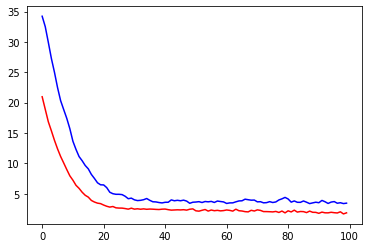

In [33]:
plt.plot(res50_train_loss_list[:100], c='r', label='Test loss')
plt.plot(res50_test_loss_list[:100], c='b', label='Train loss')

In [35]:
# Resnet18
res18_train_loss_list = []
res18_test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        av = model(inputs)
        loss = loss_func(av, gt.float())
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    res18_train_loss_list.append(train_loss)
    
    model.eval() 
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            av = model(inputs)
            loss = loss_func(av, gt.float())
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        res18_test_loss_list.append(test_loss)


    print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
    print(testing(model))#a_mse, v_mse = testing(model)[0], testing(model)[1]
    #print('test a_mse %.3f, v_mse %.3f' %(a_mse, v_mse))

[epoch 0] Train loss: 23.011, Test loss: 35.212
(16.099882383808506, 19.103894317366585)
[epoch 1] Train loss: 22.374, Test loss: 34.990
(15.973413498580436, 18.97966634611459)
[epoch 2] Train loss: 21.813, Test loss: 34.516
(15.835358209625692, 18.641522504480186)
[epoch 3] Train loss: 21.186, Test loss: 33.808
(15.607574134267292, 18.214714725989285)
[epoch 4] Train loss: 20.685, Test loss: 33.058
(15.096696683380372, 17.854962734284506)
[epoch 5] Train loss: 20.108, Test loss: 31.999
(14.535216884664512, 17.387584495271135)
[epoch 6] Train loss: 19.532, Test loss: 30.975
(13.800048921028923, 16.963590539210575)
[epoch 7] Train loss: 18.955, Test loss: 29.692
(13.036726402108659, 16.464356486724217)
[epoch 8] Train loss: 18.286, Test loss: 28.878
(12.527894177987799, 16.22506498175241)
[epoch 9] Train loss: 17.810, Test loss: 28.159
(12.127823209923664, 15.95773832093488)
[epoch 10] Train loss: 17.220, Test loss: 27.623
(12.045110994848901, 15.413792593513346)
[epoch 11] Train loss: 

(1.066528405023179, 2.3994437254780534)
[epoch 94] Train loss: 1.847, Test loss: 3.259
(1.185482325413909, 2.2268032377986686)
[epoch 95] Train loss: 1.781, Test loss: 3.273
(1.3386809629540244, 2.0333687762824963)
[epoch 96] Train loss: 1.776, Test loss: 3.535
(1.2935185445517297, 2.435527656117275)
[epoch 97] Train loss: 1.952, Test loss: 3.331
(1.0877583668864117, 2.506961500360929)
[epoch 98] Train loss: 1.911, Test loss: 3.824
(1.193133851320607, 2.4147154407361766)
[epoch 99] Train loss: 1.675, Test loss: 3.159
(1.1695957110004513, 2.0386459165289628)
[epoch 100] Train loss: 1.796, Test loss: 3.356
(1.6523979112860308, 2.0143401155669216)
[epoch 101] Train loss: 1.538, Test loss: 3.762
(1.7129294881670707, 2.1132648648496515)
[epoch 102] Train loss: 1.451, Test loss: 2.931
(1.396915522052317, 1.6702209740971004)
[epoch 103] Train loss: 1.916, Test loss: 3.741
(1.2229481477342865, 2.190926810862673)
[epoch 104] Train loss: 1.414, Test loss: 3.491
(1.4268249219084894, 1.92720193379

KeyboardInterrupt: 

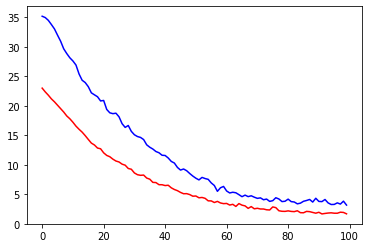

In [36]:
plt.plot(res18_train_loss_list[:100], c='r', label='Test loss')
plt.plot(res18_test_loss_list[:100], c='b', label='Train loss')

In [37]:
X_train

NameError: name 'X_train' is not defined